# Fitting a mixture of templates and parametric models

The class `iminuit.cost.Template` supports fitting a mixture of templates and parametric models. This is useful if one component has a simple shape like a Gaussian peak, while the other components are complicated and need to be estimated from simulation or a control measurement.

In this notebook, we demonstrate this usage. Our data consists of a Gaussian peak and exponential background. We fit the Gaussian peak with a parametric model and use a template to describe the background.

In [1]:
from iminuit import Minuit
from iminuit.cost import Template
from numba_stats import norm, truncexpon
import numpy as np
from matplotlib import pyplot as plt

We generate the toy data.

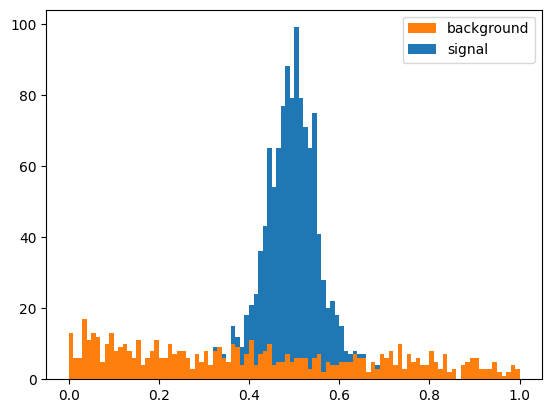

In [2]:
rng = np.random.default_rng(1)

s = rng.normal(0.5, 0.05, size=1000)
b = rng.exponential(1, size=1000)
b = b[b < 1]

ns, xe = np.histogram(s, bins=100, range=(0, 1))
nb, _ = np.histogram(b, bins=xe)
n = ns + nb

plt.stairs(nb, xe, color="C1", fill=True, label="background")
plt.stairs(n, xe, baseline=nb, color="C0", fill=True, label="signal")
plt.legend();

We now model the peaking component parametrically with a Gaussian. A template fit is an extended binned fit, so we need to provide a scaled cumulative density function like for `iminuit.cost.ExtendedBinnedNLL`. To obtain a background template, we generate more samples from the exponential distribution and make a histogram.

In [59]:
def signal(xe, n, mu, sigma):
    return n * norm.cdf(xe, mu, sigma)


# generate background template
rng = np.random.default_rng(2)
b2 = rng.exponential(1, size=1000)
b2 = b2[b2 < 1]
template = np.histogram(b2, bins=xe)[0]

c = Template(n, xe, (signal, template))
m = Minuit(c, x0_n=100, x0_mu=0.5, x0_sigma=0.05, x1=100)
m.limits["x0_n", "x1", "x0_sigma"] = (0, None)
m.limits["x0_mu"] = (0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.01 (chi2/ndof = 0.9)    │              Nfcn = 208              │
│ EDM = 6.69e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0_n     │    990    │    40     │            │            │    0    │         │       │
│ 1 │ x0_mu    │  0.4951   │  0.0021   │            │            │    0    │    1    │       │
│ 2 │ x0_sigma │  0.0484   │  0.0018   │            │            │    0    │         │       │
│ 3 │ x1       │    630    │    40     │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────┐
│          │      x0_n     x0_mu  x0_sigma        x1 │
├──────────┼─────────────────────────────────────────┤
│     x0_n │  1.45e+03  0.000552    0.0196      -452 │
│    x0_mu │  0.000552  4.31e-06 -4.92e-08  -0.00062 │
│ x0_sigma │    0.0196 -4.92e-08  3.23e-06   -0.0184 │
│       x1 │      -452  -0.00062   -0.0184  1.66e+03 │
└──────────┴─────────────────────────────────────────┘

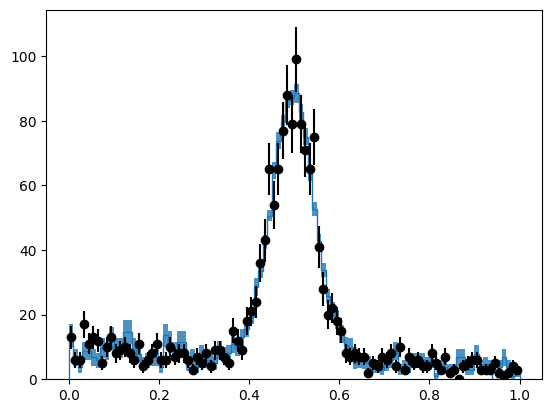

In [60]:
m.visualize()

The fit succeeded and the statistical uncertainty in the template is propagated into the result.

Note: the parameters of a parametric components are prefixed with `xn_` where `n` is the index of the component. This is to avoid name clashes between the parameter names of individual components and for clarity which parameter belongs to which component.